## Модели прогнозирования объема убоя КРС по Туркестанской области

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from IPython.display import display
import math
from prophet import Prophet
pd.set_option('display.max_columns', 130)


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Подготовка данных и EDA

In [2]:
df = pd.read_excel("Датасет по КРС.xlsx")
df.head(5)

,Регион,Период,КРС,Осадки,Поголовье: КРС,Температура
0,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-01,4455.35,9.8,372560.0,-12.490323
1,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-02,3654.20,9.8,399442.0,-10.192857
2,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-03,4287.08,8.3,425605.0,-5.870968
3,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-04,3923.21,8.8,440023.0,4.490000
4,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-05,3849.70,42.8,444647.0,14.574194


In [3]:
df_turkistan = df[df['Регион'] == 'ТУРКЕСТАНСКАЯ ОБЛАСТЬ']
df_turkistan = df_turkistan.drop('Регион', axis = 'columns')
df_turkistan.head()

,Период,КРС,Осадки,Поголовье: КРС,Температура
2411,2018-06,9079.52,3.5,1163656.0,26.623333
2412,2018-07,8805.58,0.0,1020139.0,31.296774
2413,2018-08,7908.16,0.0,998103.0,26.593548
2414,2018-09,9309.42,0.4,972607.0,21.040000
2415,2018-10,8758.15,18.5,948020.0,12.570968


In [4]:
df_turkistan = df_turkistan.rename(columns={'КРС': 'Объем убоя: КРС'})
df_turkistan.head()

,Период,Объем убоя: КРС,Осадки,Поголовье: КРС,Температура
2411,2018-06,9079.52,3.5,1163656.0,26.623333
2412,2018-07,8805.58,0.0,1020139.0,31.296774
2413,2018-08,7908.16,0.0,998103.0,26.593548
2414,2018-09,9309.42,0.4,972607.0,21.040000
2415,2018-10,8758.15,18.5,948020.0,12.570968


In [5]:
df_turkistan['Период'] = pd.to_datetime(df_turkistan['Период'], format='%Y-%m')

In [6]:
df_turkistan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 2411 to 2489
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Период           79 non-null     datetime64[ns]
 1   Объем убоя: КРС  79 non-null     float64       
 2   Осадки           79 non-null     float64       
 3   Поголовье: КРС   79 non-null     float64       
 4   Температура      79 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.7 KB


In [7]:
df_turkistan.isna().sum()

Период             0
Объем убоя: КРС    0
Осадки             0
Поголовье: КРС     0
Температура        0
dtype: int64

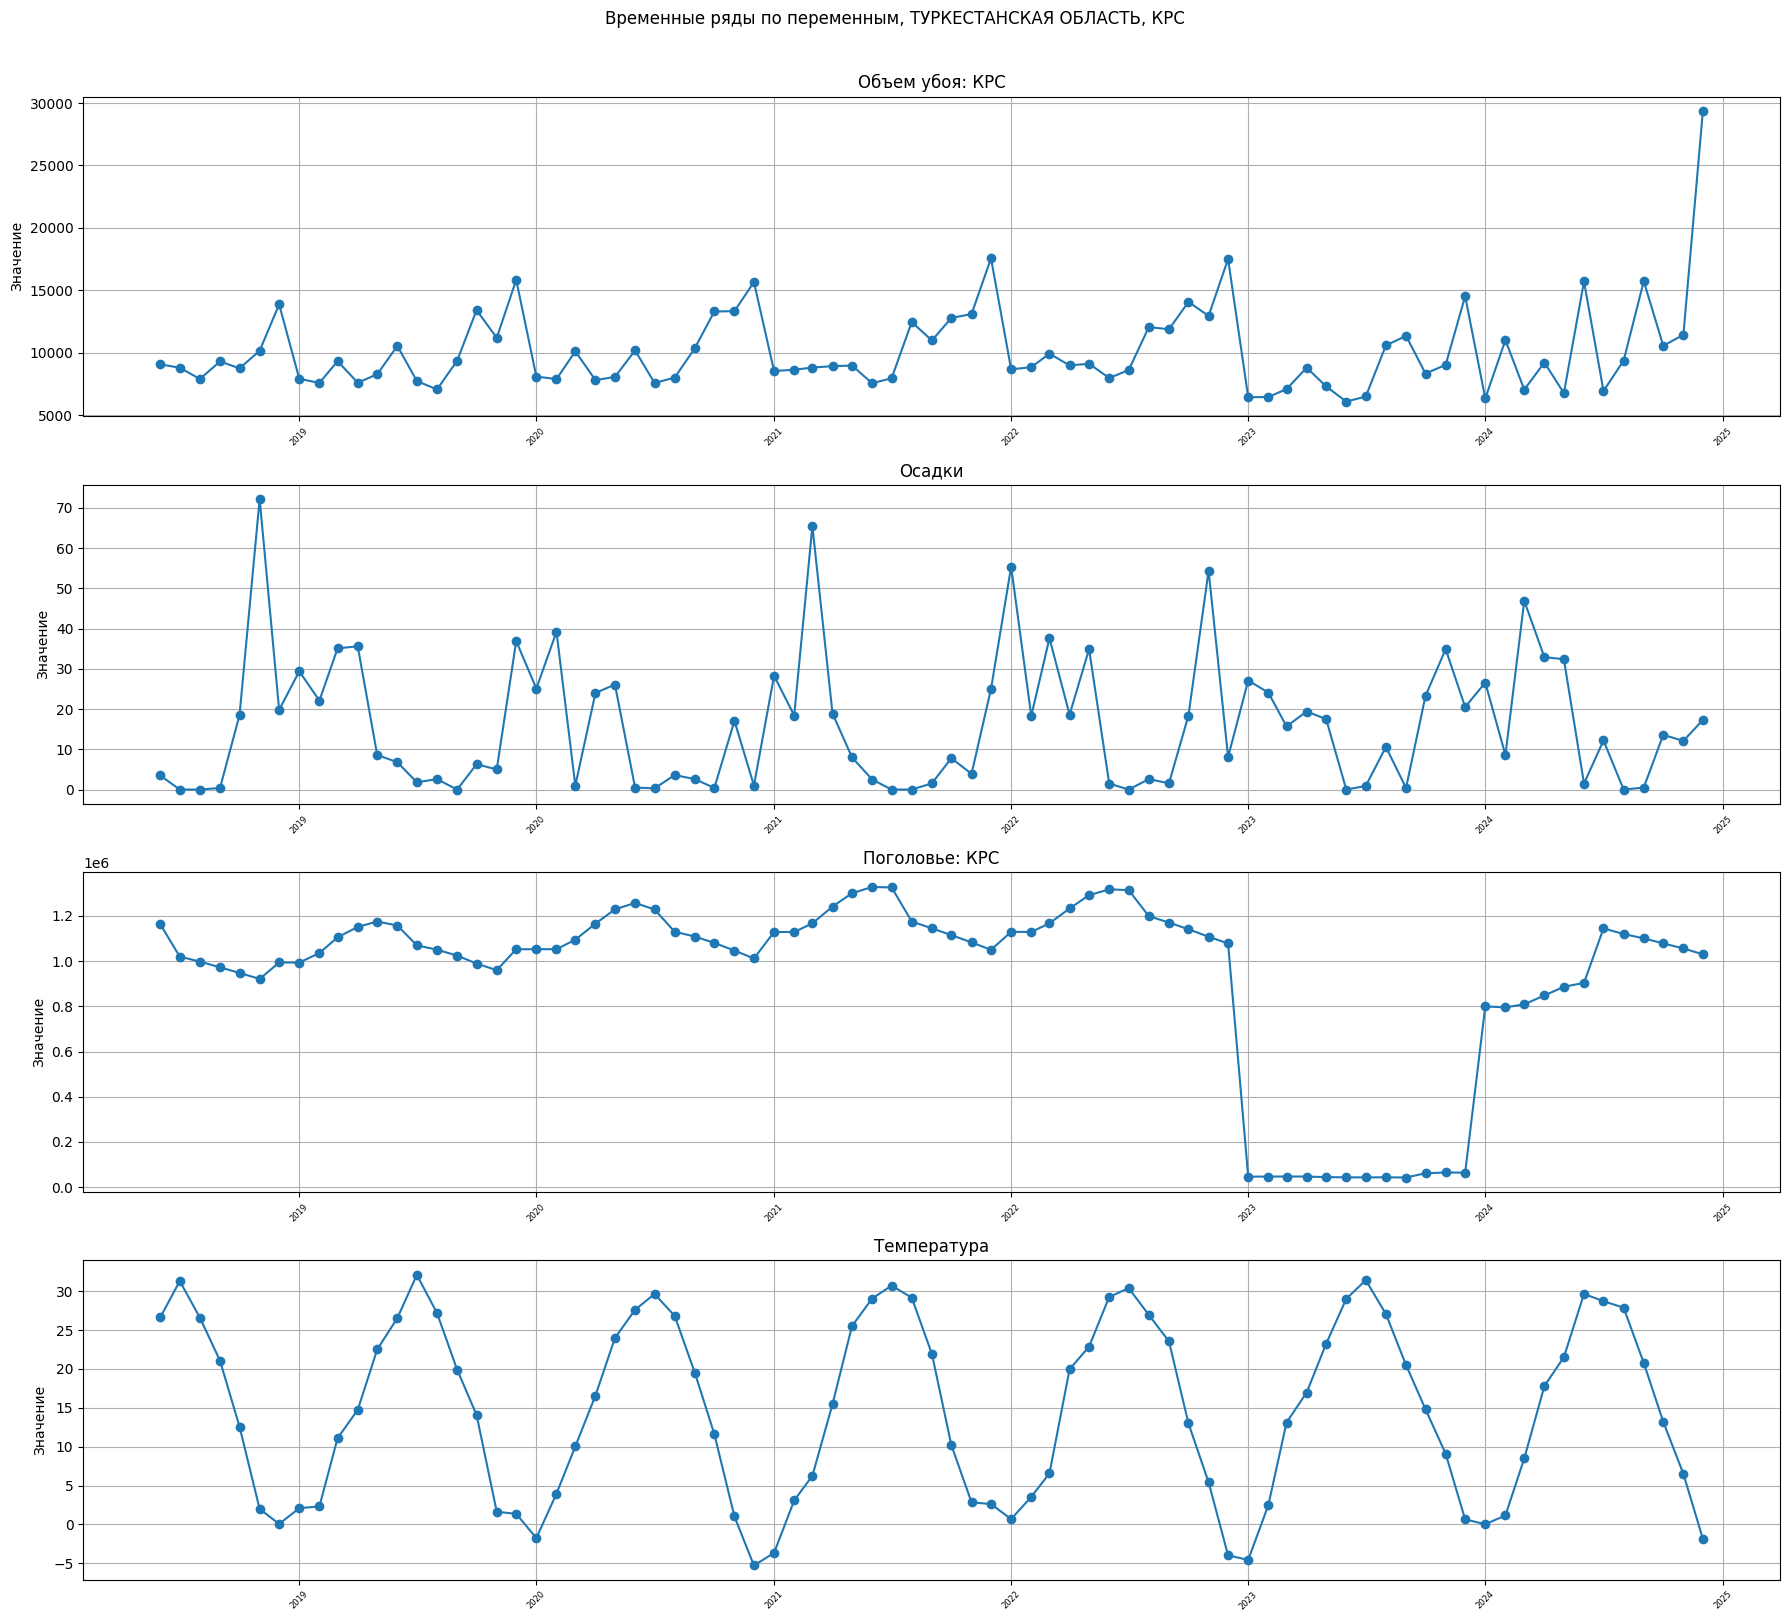

In [8]:
# Plot each variable in its own subplot
value_cols = [col for col in df_turkistan.columns if col not in ["Период"]]

n = len(value_cols)
plt.figure(figsize=(18, 4 * n))

for i, col in enumerate(value_cols, 1):
    plt.subplot(n, 1, i)
    plt.plot(df_turkistan["Период"], df_turkistan[col], marker="o")
    plt.title(f"{col}")
    plt.grid(True)
    plt.ylabel("Значение")
    plt.xticks(rotation=45, fontsize = 6)

plt.suptitle("Временные ряды по переменным, ТУРКЕСТАНСКАЯ ОБЛАСТЬ, КРС", y=1.01)
plt.tight_layout()
plt.show()


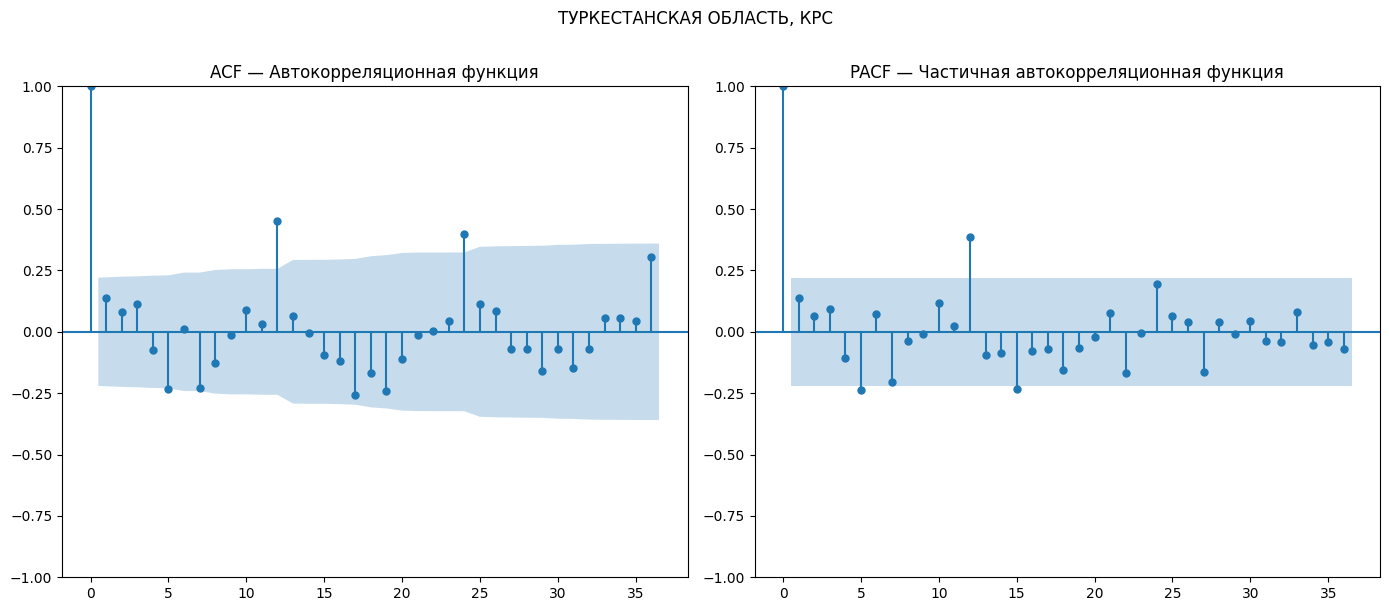

In [9]:
y = df_turkistan["Объем убоя: КРС"].sort_index()

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(y, lags=36, ax=plt.gca(), title="ACF — Автокорреляционная функция")

plt.subplot(1, 2, 2)
plot_pacf(y, lags=36, ax=plt.gca(), title="PACF — Частичная автокорреляционная функция", method="ywm")
plt.suptitle("ТУРКЕСТАНСКАЯ ОБЛАСТЬ, КРС", y=1.01)

plt.tight_layout()
plt.show()

Графики автокорреляционной и частичной автокорреляционной функций указывают на **сильную взаимосвязь показателей текущего месяца со значениями предыдущего месяца** и на возможную **годовую сезонность** (пики на +12, +24 и +36 месяцев). 

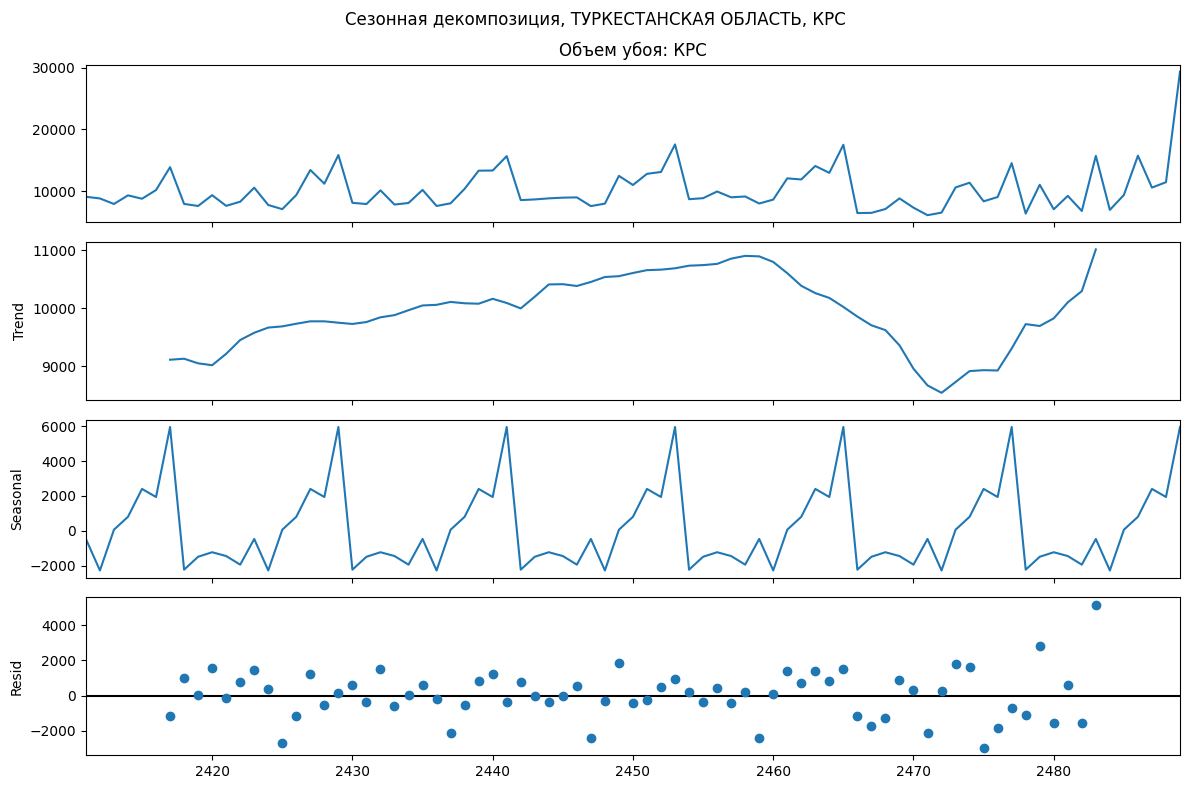

In [10]:
# Perform decomposition (period=12 for monthly data)
decomposition = seasonal_decompose(df_turkistan["Объем убоя: КРС"], model="additive", period=12)

# Plot with larger figure size
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Сезонная декомпозиция, ТУРКЕСТАНСКАЯ ОБЛАСТЬ, КРС", fontsize=12)
plt.tight_layout()
plt.show()


In [11]:
# Run ADF test
result = adfuller(df_turkistan["Объем убоя: КРС"])

# Display results
print("📊 Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("✅ The series is likely **stationary** (reject H₀).")
else:
    print("❌ The series is likely **non-stationary** (fail to reject H₀).")


📊 Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.9017
p-value: 0.7874
Critical Value (1%): -3.5336
Critical Value (5%): -2.9064
Critical Value (10%): -2.5907
❌ The series is likely **non-stationary** (fail to reject H₀).


Результаты теста ADF указывают на **нестационарность** временного ряда.

In [12]:
df_turkistan

,Период,Объем убоя: КРС,Осадки,Поголовье: КРС,Температура
2411,2018-06-01,9079.52,3.5,1163656.0,26.623333
2412,2018-07-01,8805.58,0.0,1020139.0,31.296774
2413,2018-08-01,7908.16,0.0,998103.0,26.593548
2414,2018-09-01,9309.42,0.4,972607.0,21.040000
2415,2018-10-01,8758.15,18.5,948020.0,12.570968
...,...,...,...,...,...
2485,2024-08-01,9372.79,0.0,1120067.0,27.874194
2486,2024-09-01,15738.07,0.5,1101103.0,20.766667
2487,2024-10-01,10566.50,13.6,1078583.0,13.200000
2488,2024-11-01,11441.98,12.1,1056289.0,6.500000


In [13]:
# Создание лагов t-1 до t-4 для переменных
for lag in range(1, 5):
    df_turkistan[f"КРС_t-{lag}"] = df_turkistan["Объем убоя: КРС"].shift(lag)
    df_turkistan[f"Температура_t-{lag}"] = df_turkistan["Температура"].shift(lag)
    df_turkistan[f"Осадки_t-{lag}"] = df_turkistan["Осадки"].shift(lag)
    df_turkistan[f"Поголовье: КРС_t-{lag}"] = df_turkistan["Поголовье: КРС"].shift(lag)

# Удаляем строки с NaN после сдвигов
df_turkistan_lagged = df_turkistan.dropna().copy()
df_turkistan_lagged = df_turkistan_lagged[["Период",
    "Объем убоя: КРС", "КРС_t-1", "КРС_t-2", "КРС_t-3", "КРС_t-4",
    "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4",
    "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4",
    "Поголовье: КРС", "Поголовье: КРС_t-1", "Поголовье: КРС_t-2", "Поголовье: КРС_t-3", "Поголовье: КРС_t-4"]]

df_turkistan_lagged

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
2415,2018-10-01,8758.15,9309.42,7908.16,8805.58,9079.52,12.570968,21.040000,26.593548,31.296774,26.623333,18.5,0.4,0.0,0.0,3.5,948020.0,972607.0,998103.0,1020139.0,1163656.0
2416,2018-11-01,10167.94,8758.15,9309.42,7908.16,8805.58,1.980000,12.570968,21.040000,26.593548,31.296774,72.2,18.5,0.4,0.0,0.0,921291.0,948020.0,972607.0,998103.0,1020139.0
2417,2018-12-01,13879.82,10167.94,8758.15,9309.42,7908.16,0.061290,1.980000,12.570968,21.040000,26.593548,19.8,72.2,18.5,0.4,0.0,994197.0,921291.0,948020.0,972607.0,998103.0
2418,2019-01-01,7920.24,13879.82,10167.94,8758.15,9309.42,2.090323,0.061290,1.980000,12.570968,21.040000,29.4,19.8,72.2,18.5,0.4,993585.0,994197.0,921291.0,948020.0,972607.0
2419,2019-02-01,7586.87,7920.24,13879.82,10167.94,8758.15,2.314286,2.090323,0.061290,1.980000,12.570968,22.1,29.4,19.8,72.2,18.5,1036129.0,993585.0,994197.0,921291.0,948020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485,2024-08-01,9372.79,6948.86,15715.54,6776.16,9224.01,27.874194,28.700000,29.650000,21.509677,17.793333,0.0,12.2,1.5,32.4,32.9,1120067.0,1145108.0,904028.0,886504.0,848304.0
2486,2024-09-01,15738.07,9372.79,6948.86,15715.54,6776.16,20.766667,27.874194,28.700000,29.650000,21.509677,0.5,0.0,12.2,1.5,32.4,1101103.0,1120067.0,1145108.0,904028.0,886504.0
2487,2024-10-01,10566.50,15738.07,9372.79,6948.86,15715.54,13.200000,20.766667,27.874194,28.700000,29.650000,13.6,0.5,0.0,12.2,1.5,1078583.0,1101103.0,1120067.0,1145108.0,904028.0
2488,2024-11-01,11441.98,10566.50,15738.07,9372.79,6948.86,6.500000,13.200000,20.766667,27.874194,28.700000,12.1,13.6,0.5,0.0,12.2,1056289.0,1078583.0,1101103.0,1120067.0,1145108.0


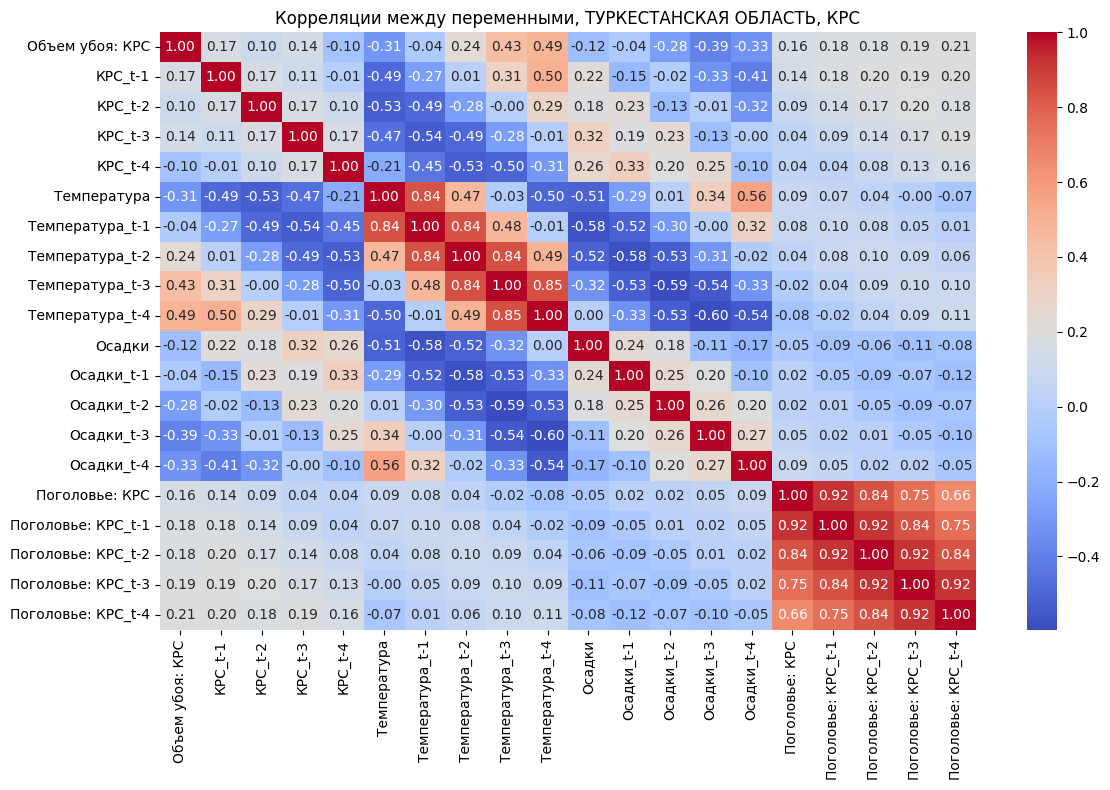

In [14]:
df_corr = df_turkistan_lagged[[col for col in df_turkistan_lagged.columns if col not in ["Период"]]].dropna()

# 1. Correlation matrix
corr_matrix = df_corr.corr()

# 2. Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между переменными, ТУРКЕСТАНСКАЯ ОБЛАСТЬ, КРС")
plt.tight_layout()
plt.show()

<!-- * Умеренная позитивная корреляция (0.51) между показателями объема убоя за все соседствующие временные периоды: между t0 и t-1, t-1 и t-2 так далее. Это свидетельствует о наличии автокорреляции в данных: значения показателя в текущем месяце частично объясняются значениями в соседних месяцах. Это типичный признак временных рядов, особенно в аграрной статистике, где производственные процессы имеют инерционный характер. Это также означает, что модели авторегрессии (AR, ARIMA, SARIMA) могут хорошо работать на этих данных, так как текущие значения "похожи" на недавние;
* Корреляция между значениями обема убоя текущего месяца и предыдущих месяцев постепенно ослабевает, в особенности после лага в t-3. Это может быть связано с тем, что основной объём данных формируется за счёт отчетности крестьянских/фермерских хозяйств и хозяйств населения, которые сдают отчетность ежеквартально. В результате, месячные значения могут быть получены путём декомпозиции квартальных показателей, что сглаживает внутриквартальные различия, но снижает связь между кварталами.
* Температура и осадки, в том числе за предыдущие месяцы, умеренно негативно коррелируют с показателями обема убоя; 
* Между показателями объема убоя и поголовья в рамках значений текущего и предыдущего месяцев отмечается незначительная позитивная корреляция (0.19 и 0.12).

**МОЖНО ЕЩЕ ДОБАВИТЬ ВЫВОДЫ ПРИ НЕОБХОДИМОСТИ** -->

отсечь некоторые регрессоры на данном этапе

### Models

#### Многофакторная регрессия

In [15]:
df_turkistan = df_turkistan[["Период",
    "Объем убоя: КРС", "КРС_t-1", "КРС_t-2", "КРС_t-3", "КРС_t-4",
    "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4",
    "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4",
    "Поголовье: КРС", "Поголовье: КРС_t-1", "Поголовье: КРС_t-2", "Поголовье: КРС_t-3", "Поголовье: КРС_t-4"]]
df_turkistan

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
2411,2018-06-01,9079.52,NaN,NaN,NaN,NaN,26.623333,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,1163656.0,NaN,NaN,NaN,NaN
2412,2018-07-01,8805.58,9079.52,NaN,NaN,NaN,31.296774,26.623333,NaN,NaN,NaN,0.0,3.5,NaN,NaN,NaN,1020139.0,1163656.0,NaN,NaN,NaN
2413,2018-08-01,7908.16,8805.58,9079.52,NaN,NaN,26.593548,31.296774,26.623333,NaN,NaN,0.0,0.0,3.5,NaN,NaN,998103.0,1020139.0,1163656.0,NaN,NaN
2414,2018-09-01,9309.42,7908.16,8805.58,9079.52,NaN,21.040000,26.593548,31.296774,26.623333,NaN,0.4,0.0,0.0,3.5,NaN,972607.0,998103.0,1020139.0,1163656.0,NaN
2415,2018-10-01,8758.15,9309.42,7908.16,8805.58,9079.52,12.570968,21.040000,26.593548,31.296774,26.623333,18.5,0.4,0.0,0.0,3.5,948020.0,972607.0,998103.0,1020139.0,1163656.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485,2024-08-01,9372.79,6948.86,15715.54,6776.16,9224.01,27.874194,28.700000,29.650000,21.509677,17.793333,0.0,12.2,1.5,32.4,32.9,1120067.0,1145108.0,904028.0,886504.0,848304.0
2486,2024-09-01,15738.07,9372.79,6948.86,15715.54,6776.16,20.766667,27.874194,28.700000,29.650000,21.509677,0.5,0.0,12.2,1.5,32.4,1101103.0,1120067.0,1145108.0,904028.0,886504.0
2487,2024-10-01,10566.50,15738.07,9372.79,6948.86,15715.54,13.200000,20.766667,27.874194,28.700000,29.650000,13.6,0.5,0.0,12.2,1.5,1078583.0,1101103.0,1120067.0,1145108.0,904028.0
2488,2024-11-01,11441.98,10566.50,15738.07,9372.79,6948.86,6.500000,13.200000,20.766667,27.874194,28.700000,12.1,13.6,0.5,0.0,12.2,1056289.0,1078583.0,1101103.0,1120067.0,1145108.0


In [16]:
df_turkistan_lagged

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
2415,2018-10-01,8758.15,9309.42,7908.16,8805.58,9079.52,12.570968,21.040000,26.593548,31.296774,26.623333,18.5,0.4,0.0,0.0,3.5,948020.0,972607.0,998103.0,1020139.0,1163656.0
2416,2018-11-01,10167.94,8758.15,9309.42,7908.16,8805.58,1.980000,12.570968,21.040000,26.593548,31.296774,72.2,18.5,0.4,0.0,0.0,921291.0,948020.0,972607.0,998103.0,1020139.0
2417,2018-12-01,13879.82,10167.94,8758.15,9309.42,7908.16,0.061290,1.980000,12.570968,21.040000,26.593548,19.8,72.2,18.5,0.4,0.0,994197.0,921291.0,948020.0,972607.0,998103.0
2418,2019-01-01,7920.24,13879.82,10167.94,8758.15,9309.42,2.090323,0.061290,1.980000,12.570968,21.040000,29.4,19.8,72.2,18.5,0.4,993585.0,994197.0,921291.0,948020.0,972607.0
2419,2019-02-01,7586.87,7920.24,13879.82,10167.94,8758.15,2.314286,2.090323,0.061290,1.980000,12.570968,22.1,29.4,19.8,72.2,18.5,1036129.0,993585.0,994197.0,921291.0,948020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485,2024-08-01,9372.79,6948.86,15715.54,6776.16,9224.01,27.874194,28.700000,29.650000,21.509677,17.793333,0.0,12.2,1.5,32.4,32.9,1120067.0,1145108.0,904028.0,886504.0,848304.0
2486,2024-09-01,15738.07,9372.79,6948.86,15715.54,6776.16,20.766667,27.874194,28.700000,29.650000,21.509677,0.5,0.0,12.2,1.5,32.4,1101103.0,1120067.0,1145108.0,904028.0,886504.0
2487,2024-10-01,10566.50,15738.07,9372.79,6948.86,15715.54,13.200000,20.766667,27.874194,28.700000,29.650000,13.6,0.5,0.0,12.2,1.5,1078583.0,1101103.0,1120067.0,1145108.0,904028.0
2488,2024-11-01,11441.98,10566.50,15738.07,9372.79,6948.86,6.500000,13.200000,20.766667,27.874194,28.700000,12.1,13.6,0.5,0.0,12.2,1056289.0,1078583.0,1101103.0,1120067.0,1145108.0


In [17]:
df_vif = df_turkistan_lagged[[col for col in df_turkistan_lagged.columns if col not in ["Период"]]]

X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Объем убоя: КРС"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data

,Variable,VIF
0,const,227.191049
1,КРС_t-1,1.943023
2,КРС_t-2,2.019392
3,КРС_t-3,1.987157
4,КРС_t-4,1.812650
5,Температура,26.227823
6,Температура_t-1,31.557044
7,Температура_t-2,31.799518
8,Температура_t-3,33.894169
9,Температура_t-4,26.214585


In [18]:
def forward_selection(data, target, candidate_features, criterion="adj_r2"):
    remaining = list(candidate_features)
    selected = []
    best_score = -float("inf")
    best_model = None

    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            features = selected + [candidate]
            X = sm.add_constant(data[features])
            y = data[target]
            model = sm.OLS(y, X).fit()

            if criterion == "adj_r2":
                score = model.rsquared_adj
            elif criterion == "aic":
                score = -model.aic  # negative for maximizing
            else:
                raise ValueError("criterion must be 'adj_r2' or 'aic'")

            scores_with_candidates.append((score, candidate, model))

        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate, model = scores_with_candidates[0]

        if best_new_score > best_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            best_score = best_new_score
            best_model = model
            print(f"✅ Added: {best_candidate}, {criterion.upper()}: {best_score:.4f}")
        else:
            print("⛔ No improvement. Stopping.")
            break

    return selected, best_model


In [19]:
# Define target and candidate predictors
target = "Объем убоя: КРС"
candidate_features = ['Осадки', 'Осадки_t-3', 'Осадки_t-2', 'Осадки_t-1',
    'Температура', 'Температура_t-3', 'Температура_t-2', 'Температура_t-1',
    'Поголовье: КРС', 'Поголовье: КРС_t-3', 'Поголовье: КРС_t-2', 'Поголовье: КРС_t-1',
    'КРС_t-4', 'КРС_t-3', 'КРС_t-2', 'КРС_t-1']

# Drop rows with missing values
df_mlr = df_turkistan[candidate_features + [target]].dropna()

# Run forward selection
selected_features, final_model = forward_selection(df_mlr, target, candidate_features, criterion="adj_r2")

# Show final summary

print(selected_features)
print("\n🧾 Final Model Summary:")
print(final_model.summary())



✅ Added: Температура_t-3, ADJ_R2: 0.1776
✅ Added: Температура, ADJ_R2: 0.2598
✅ Added: Поголовье: КРС, ADJ_R2: 0.2882
✅ Added: КРС_t-1, ADJ_R2: 0.3149
✅ Added: Осадки, ADJ_R2: 0.3282
✅ Added: КРС_t-2, ADJ_R2: 0.3438
✅ Added: КРС_t-3, ADJ_R2: 0.3439
⛔ No improvement. Stopping.
['Температура_t-3', 'Температура', 'Поголовье: КРС', 'КРС_t-1', 'Осадки', 'КРС_t-2', 'КРС_t-3']

🧾 Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:        Объем убоя: КРС   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     6.541
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           6.86e-06
Time:                        18:45:30   Log-Likelihood:                -700.41
No. Observations:                  75   AIC:                             1417.
Df Residuals:                      67   BIC:      

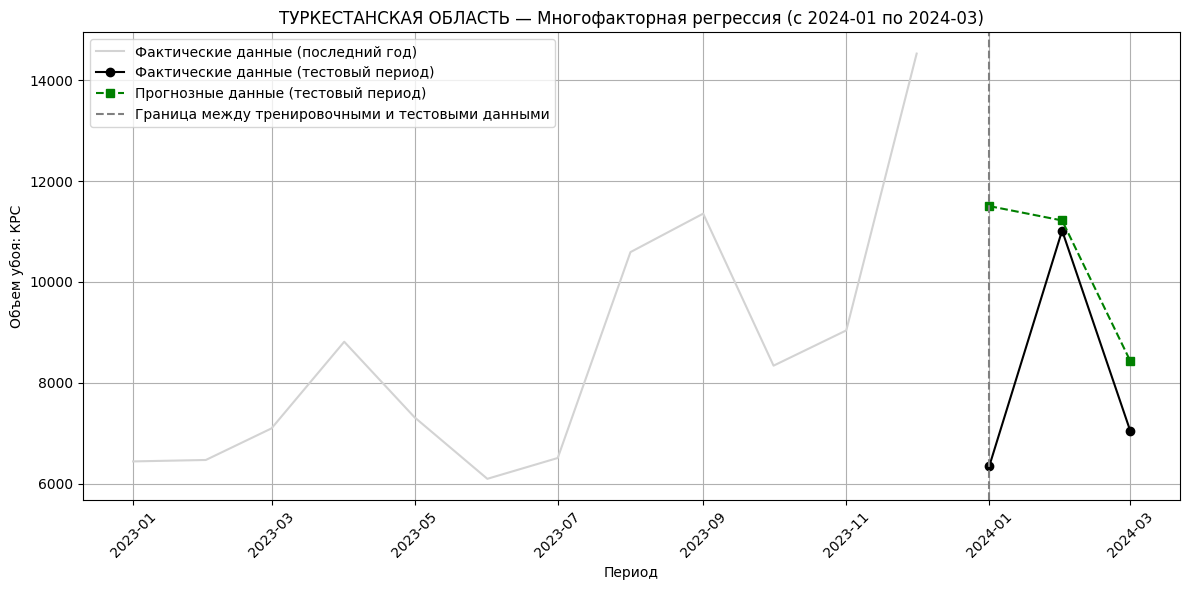

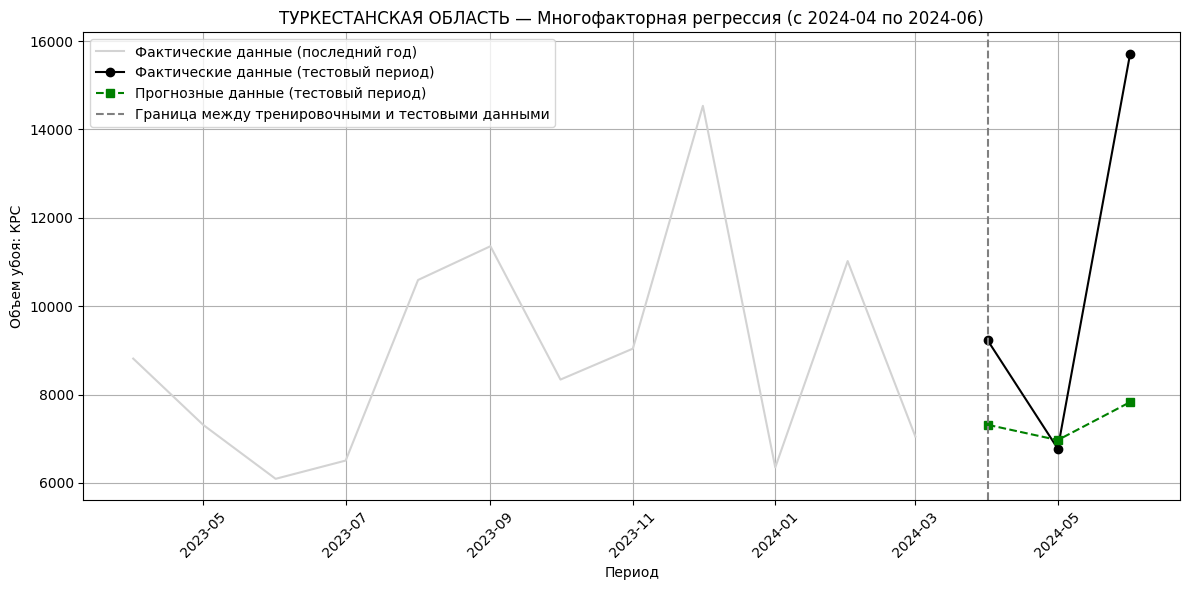

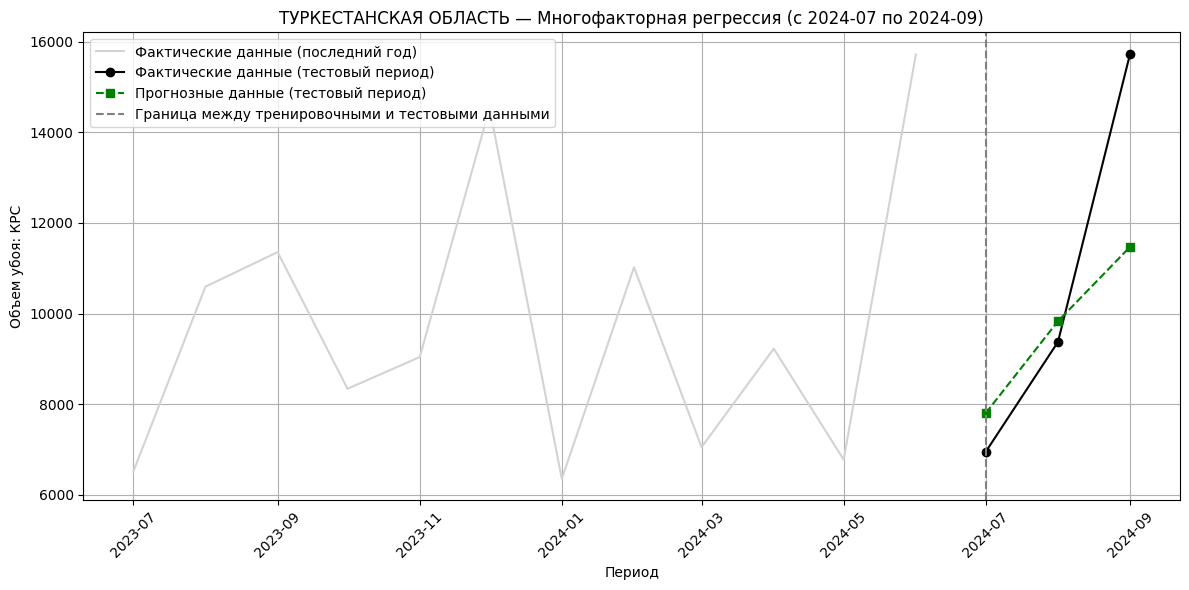

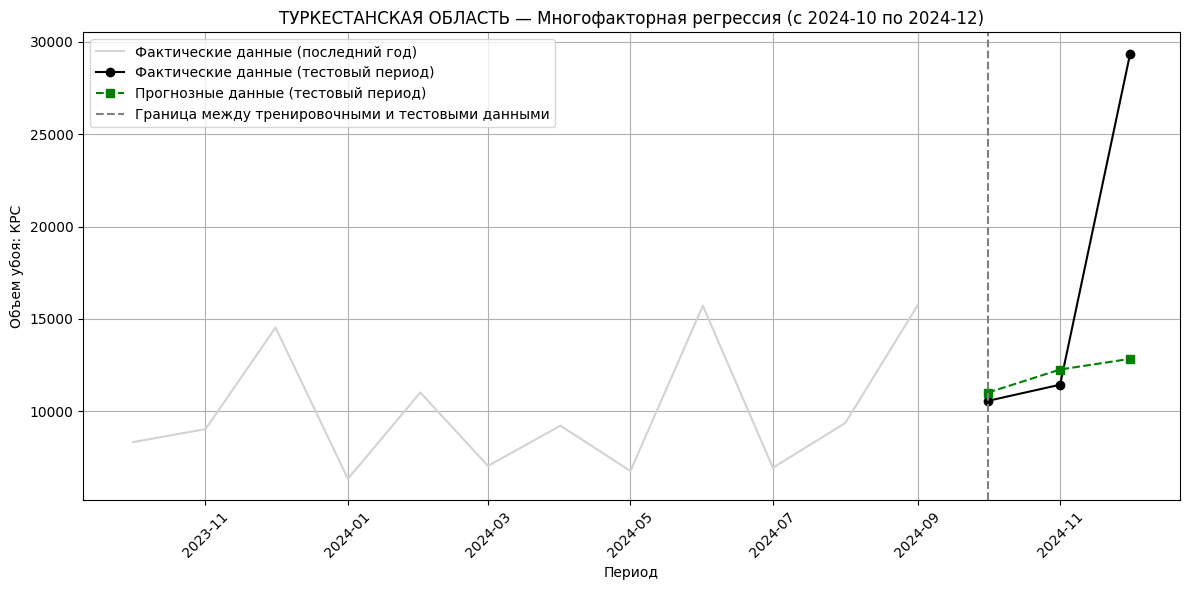

In [20]:
# Ensure your dataframe is sorted by time
df = df_turkistan.sort_values("Период").dropna().copy()

# # Selected features
# selected_features = [
#     'Температура_t-1', 'Поголовье: КРС', 'Температура_t-3', 'КРС_t-4', 'КРС_t-2', 'Осадки_t-1', 'Осадки_t-3', 'Поголовье: КРС_t-1'
# ]

target = "Объем убоя: КРС"
results = []

# Define 4 rolling test sets for 2024
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    # Drop NAs and align predictors
    X_train = sm.add_constant(train_df[selected_features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[selected_features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    # print(y_test, '\n', y_pred, '\n', y_test-y_pred)

    r2 = r2_score(y_test, y_pred)
    # print("Zero values in y_test:", (y_test == 0).sum())


    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ТУРКЕСТАНСКАЯ ОБЛАСТЬ — Многофакторная регрессия (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [21]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE   MAPE (%)        R²
0  2024-01 to 2024-03  3083.478411  2246.733823  34.204246 -1.249014
1  2024-04 to 2024-06  4685.486787  3329.268720  24.576092 -0.543090
2  2024-07 to 2024-09  2524.155410  1858.214391  14.752680  0.536225
3  2024-10 to 2024-12  9548.862295  5927.145361  22.555670 -0.216606
4             Average  4960.495726  3340.340574  24.022172 -0.368121


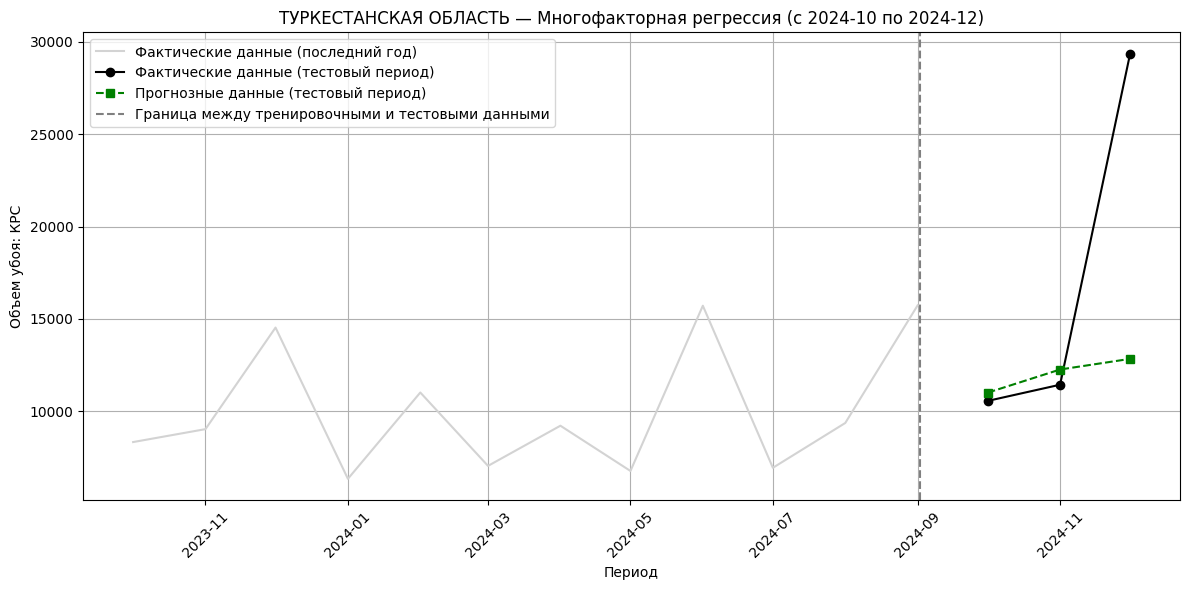

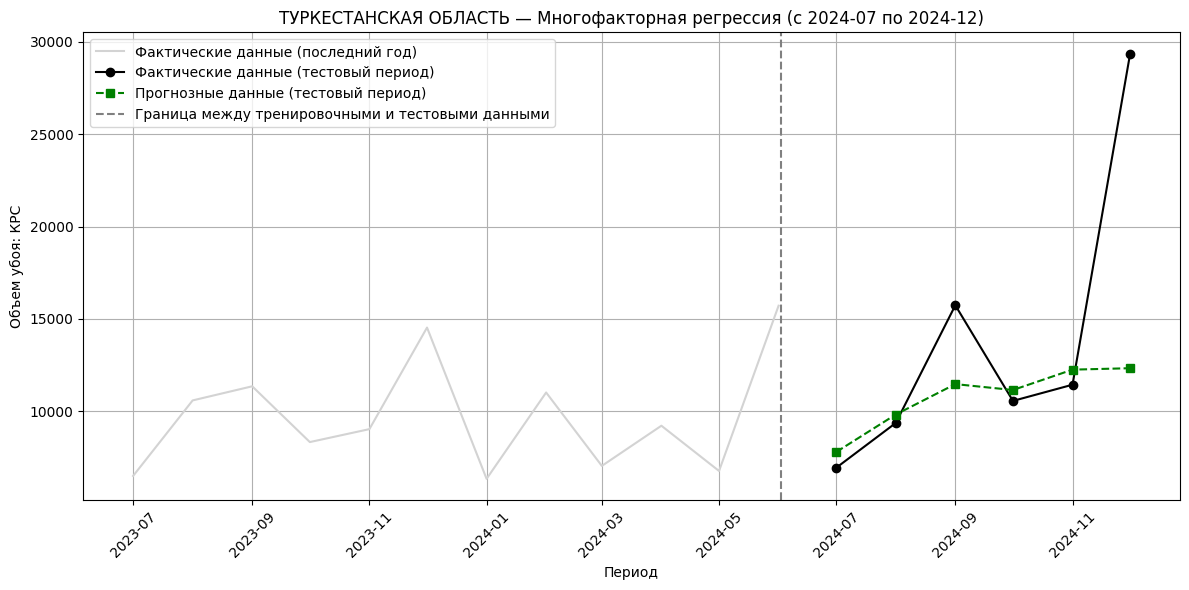

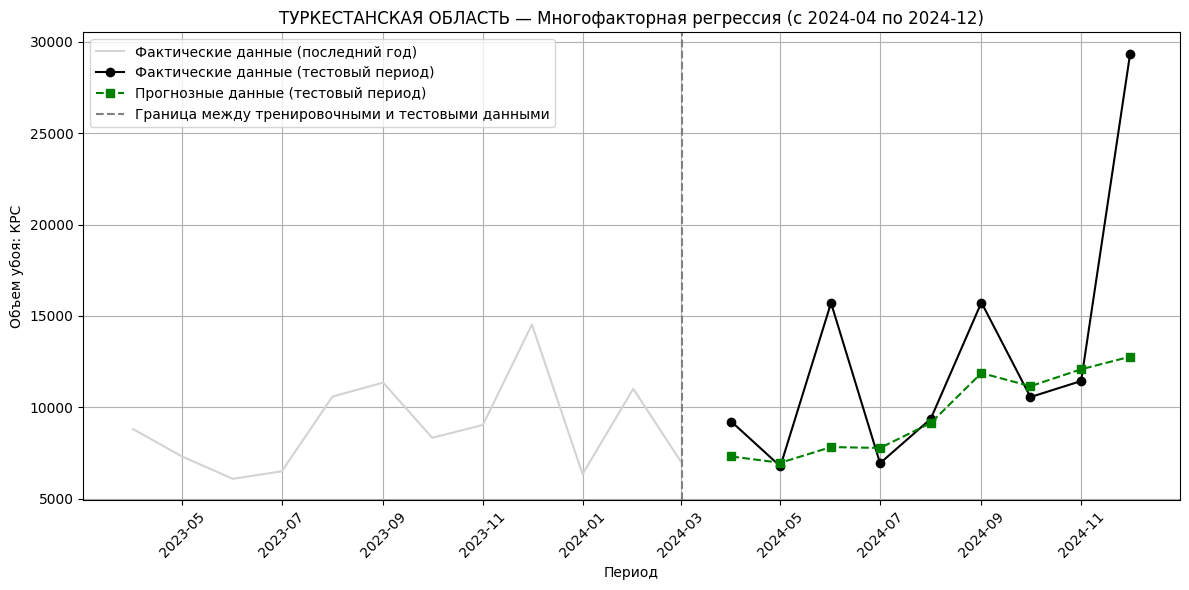

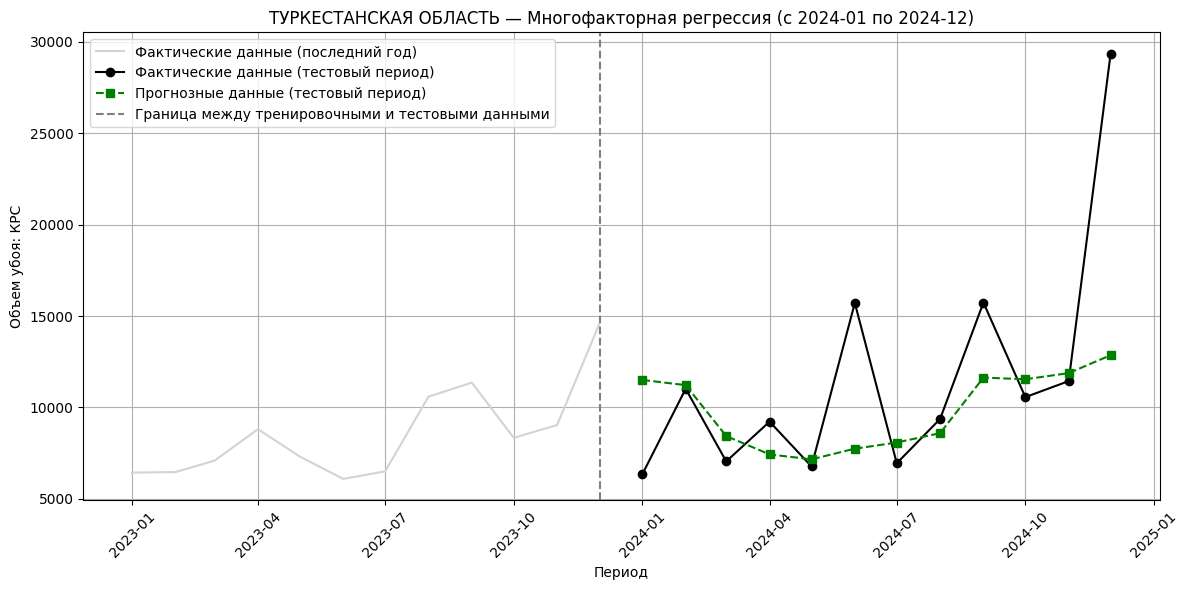

In [22]:
# Ensure your dataframe is sorted by time
df = df_turkistan.sort_values("Период").dropna().copy()

# # Selected features
# selected_features = [
#     'Температура_t-1', 'Поголовье: КРС', 'Температура_t-3', 'КРС_t-4', 'КРС_t-2', 'Осадки_t-1', 'Осадки_t-3', 'Поголовье: КРС_t-1'
# ]

target = "Объем убоя: КРС"
results = []

# Define 4 rolling test sets for 2024
horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    # Drop NAs and align predictors
    X_train = sm.add_constant(train_df[selected_features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[selected_features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    # print(y_test, '\n', y_pred, '\n', y_test-y_pred)

    r2 = r2_score(y_test, y_pred)
    # print("Zero values in y_test:", (y_test == 0).sum())


    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ТУРКЕСТАНСКАЯ ОБЛАСТЬ — Многофакторная регрессия (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [23]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE   MAPE (%)        R²
0  2024-10 to 2024-12  9548.862295  5927.145361  22.555670 -0.216606
1  2024-07 to 2024-12  7185.091454  3999.578130  19.156102  0.056060
2  2024-04 to 2024-12  6299.749900  3636.127194  20.044025  0.091212
3  2024-01 to 2024-12  5681.249160  3400.785861  24.864968  0.147626
4             Average  7178.738202  4240.909136  21.655191  0.019573


In [24]:
df_turkistan

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
2411,2018-06-01,9079.52,NaN,NaN,NaN,NaN,26.623333,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,1163656.0,NaN,NaN,NaN,NaN
2412,2018-07-01,8805.58,9079.52,NaN,NaN,NaN,31.296774,26.623333,NaN,NaN,NaN,0.0,3.5,NaN,NaN,NaN,1020139.0,1163656.0,NaN,NaN,NaN
2413,2018-08-01,7908.16,8805.58,9079.52,NaN,NaN,26.593548,31.296774,26.623333,NaN,NaN,0.0,0.0,3.5,NaN,NaN,998103.0,1020139.0,1163656.0,NaN,NaN
2414,2018-09-01,9309.42,7908.16,8805.58,9079.52,NaN,21.040000,26.593548,31.296774,26.623333,NaN,0.4,0.0,0.0,3.5,NaN,972607.0,998103.0,1020139.0,1163656.0,NaN
2415,2018-10-01,8758.15,9309.42,7908.16,8805.58,9079.52,12.570968,21.040000,26.593548,31.296774,26.623333,18.5,0.4,0.0,0.0,3.5,948020.0,972607.0,998103.0,1020139.0,1163656.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485,2024-08-01,9372.79,6948.86,15715.54,6776.16,9224.01,27.874194,28.700000,29.650000,21.509677,17.793333,0.0,12.2,1.5,32.4,32.9,1120067.0,1145108.0,904028.0,886504.0,848304.0
2486,2024-09-01,15738.07,9372.79,6948.86,15715.54,6776.16,20.766667,27.874194,28.700000,29.650000,21.509677,0.5,0.0,12.2,1.5,32.4,1101103.0,1120067.0,1145108.0,904028.0,886504.0
2487,2024-10-01,10566.50,15738.07,9372.79,6948.86,15715.54,13.200000,20.766667,27.874194,28.700000,29.650000,13.6,0.5,0.0,12.2,1.5,1078583.0,1101103.0,1120067.0,1145108.0,904028.0
2488,2024-11-01,11441.98,10566.50,15738.07,9372.79,6948.86,6.500000,13.200000,20.766667,27.874194,28.700000,12.1,13.6,0.5,0.0,12.2,1056289.0,1078583.0,1101103.0,1120067.0,1145108.0


#### SARIMA (auto-arima)

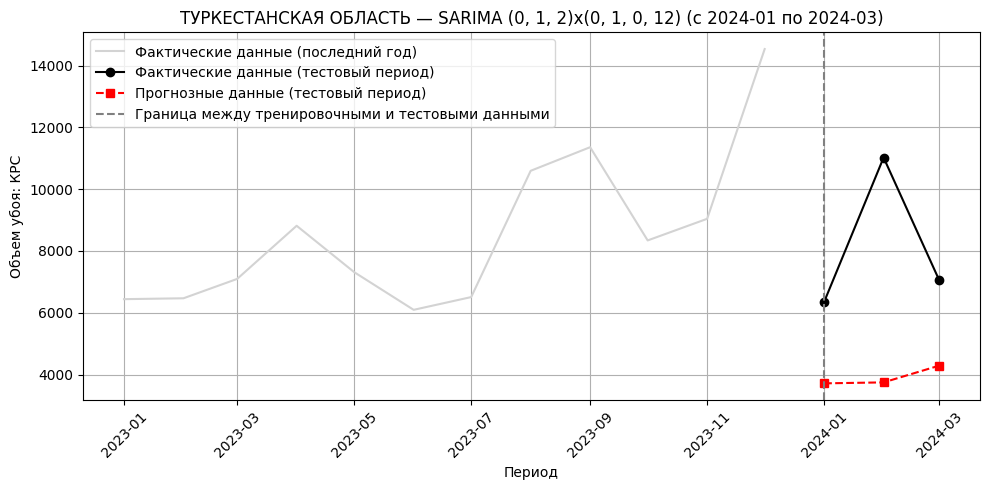

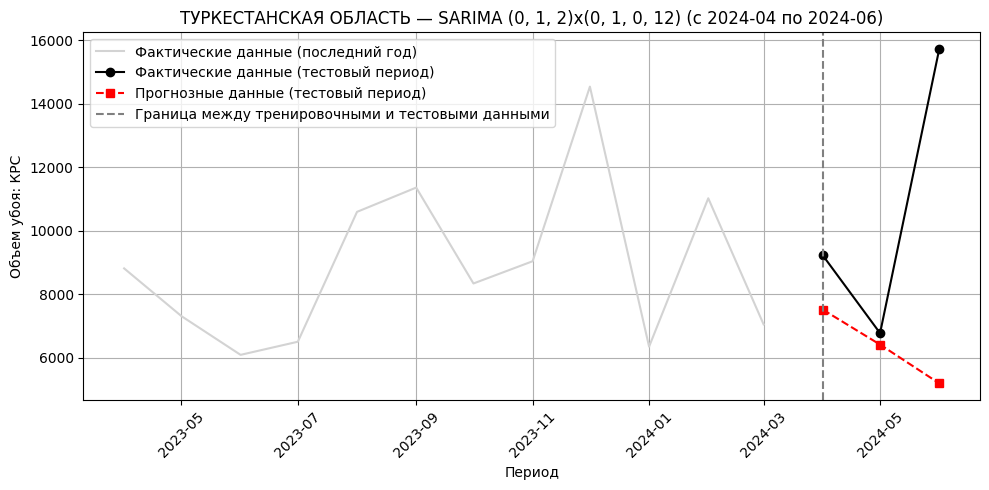

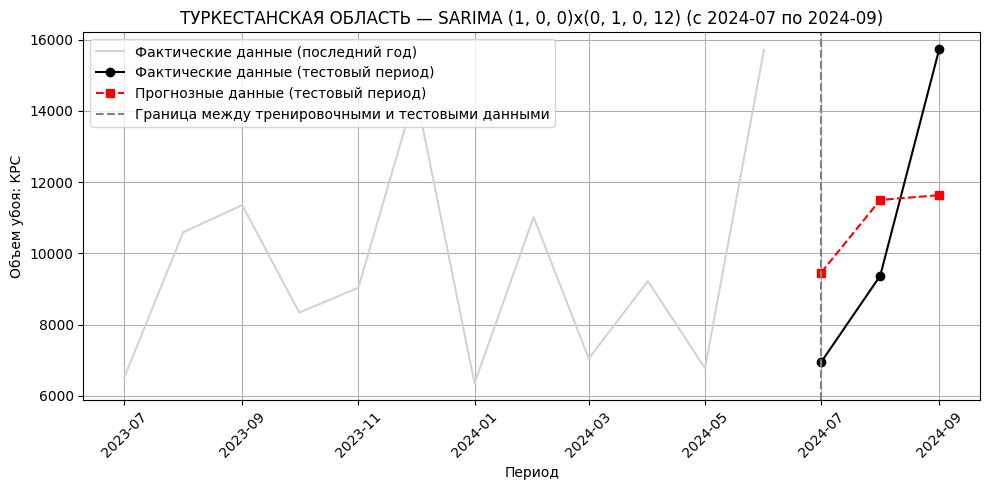

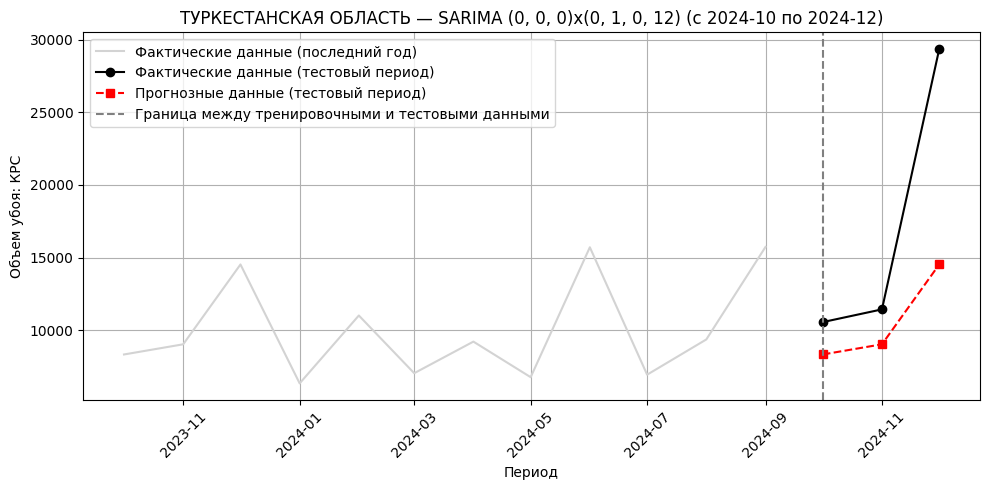

In [25]:
df = df_turkistan.sort_values("Период").copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

# Определим 4 тестовых периода на 3 месяца
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=3)
        forecast = pd.Series(forecast).reset_index(drop=True)
        # forecast = pd.Series(model.predict(n_periods=len(y_test)), index=y_test.index)
        # print(y_test, '\n', forecast, '\n', y_test-forecast)
        # print("Are indices equal?", y_test.index.equals(forecast.index))



        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ТУРКЕСТАНСКАЯ ОБЛАСТЬ — SARIMA {model.order}x{model.seasonal_order} (с {test_start.strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [26]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  4743.904988  4225.006375  48.904223    (0, 1, 2)   
1  2024-04 to 2024-06  6155.932798  4195.311580  30.250675    (0, 1, 2)   
2  2024-07 to 2024-09  3037.534479  2914.986411  28.319363    (1, 0, 0)   
3  2024-10 to 2024-12  8763.003376  6483.236667  30.854099    (0, 0, 0)   
4             Average  5675.093910  4454.635258  34.582090          NaN   

  Seasonal order  
0  (0, 1, 0, 12)  
1  (0, 1, 0, 12)  
2  (0, 1, 0, 12)  
3  (0, 1, 0, 12)  
4            NaN  


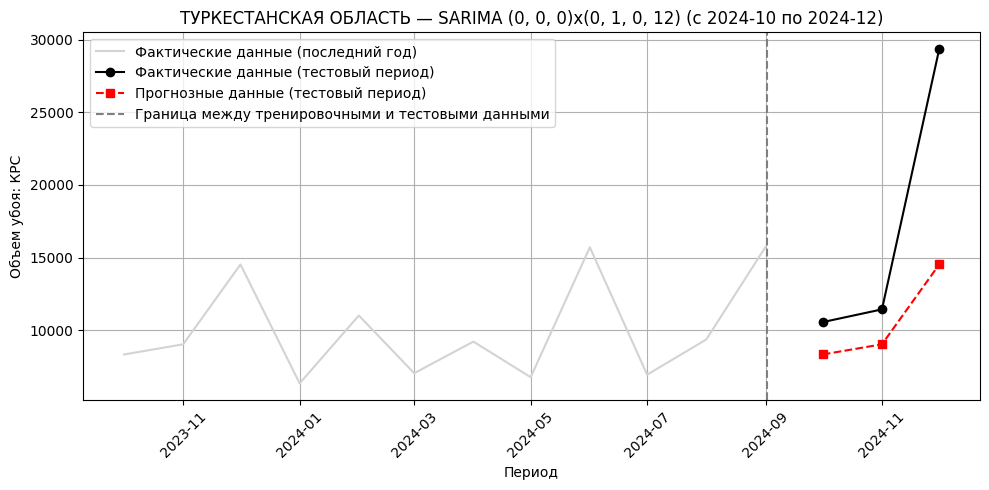

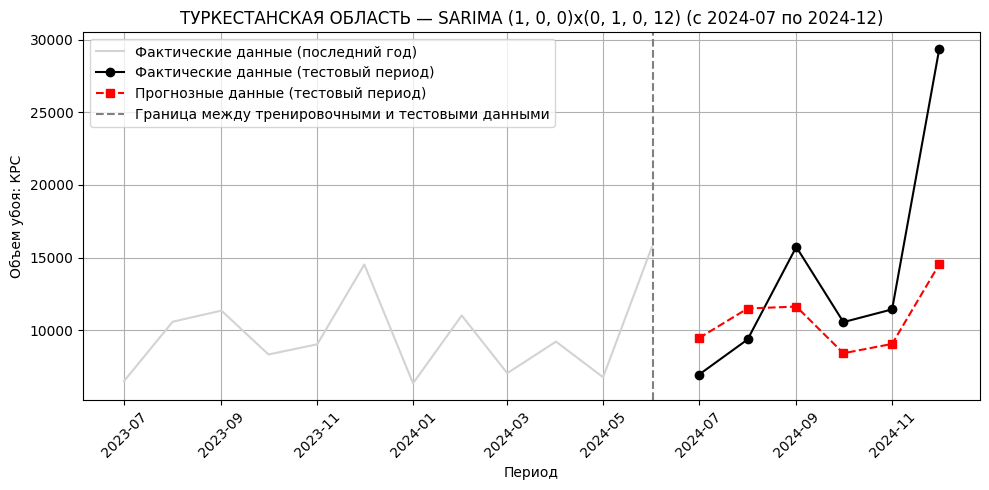

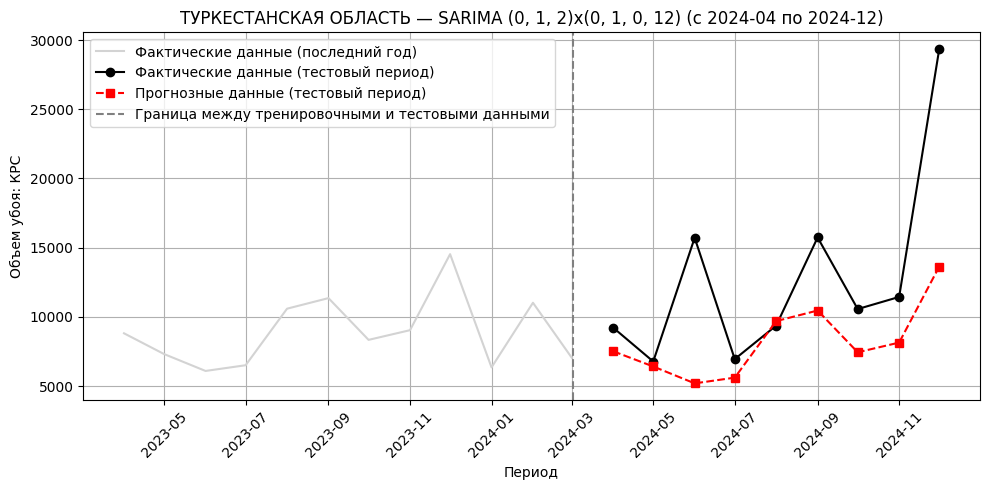

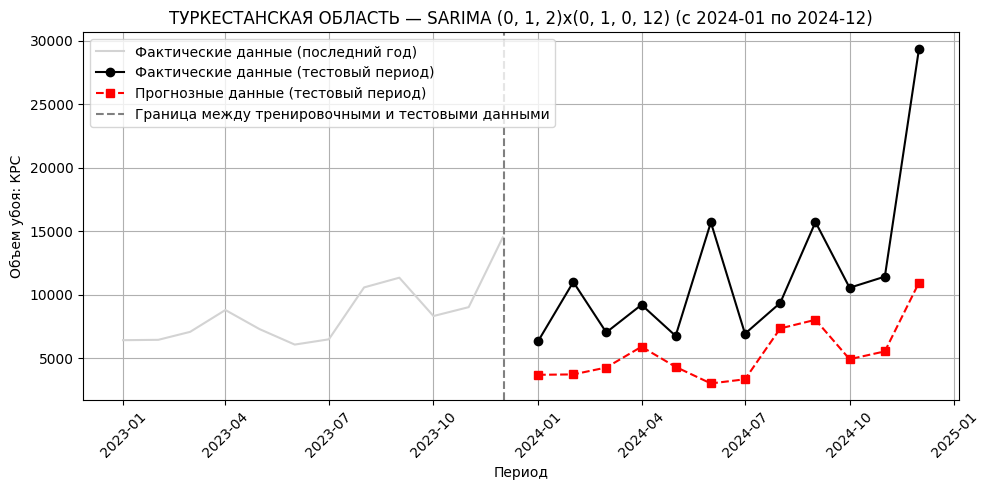

In [27]:
df = df_turkistan.sort_values("Период").copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)
    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=horizon)
        forecast = pd.Series(forecast).reset_index(drop=True)
        # forecast = pd.Series(model.predict(n_periods=len(y_test)), index=y_test.index)
        # print(y_test, '\n', forecast, '\n', y_test-forecast)
        # print("Are indices equal?", y_test.index.equals(forecast.index))



        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ТУРКЕСТАНСКАЯ ОБЛАСТЬ — SARIMA {model.order}x{model.seasonal_order} (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [28]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-10 to 2024-12  8763.003376  6483.236667  30.854099    (0, 0, 0)   
1  2024-07 to 2024-12  6548.663838  4679.074688  29.408460    (1, 0, 0)   
2  2024-04 to 2024-12  6758.596541  4629.555926  28.771756    (0, 1, 2)   
3  2024-01 to 2024-12  7775.754263  6189.688333  49.030173    (0, 1, 2)   
4             Average  7461.504504  5495.388904  34.516122          NaN   

  Seasonal order  
0  (0, 1, 0, 12)  
1  (0, 1, 0, 12)  
2  (0, 1, 0, 12)  
3  (0, 1, 0, 12)  
4            NaN  


#### SARIMAX

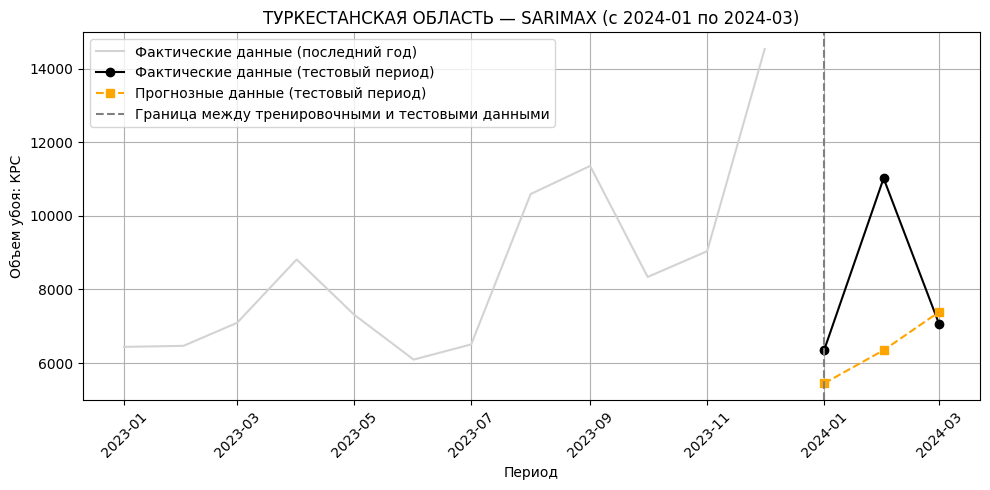

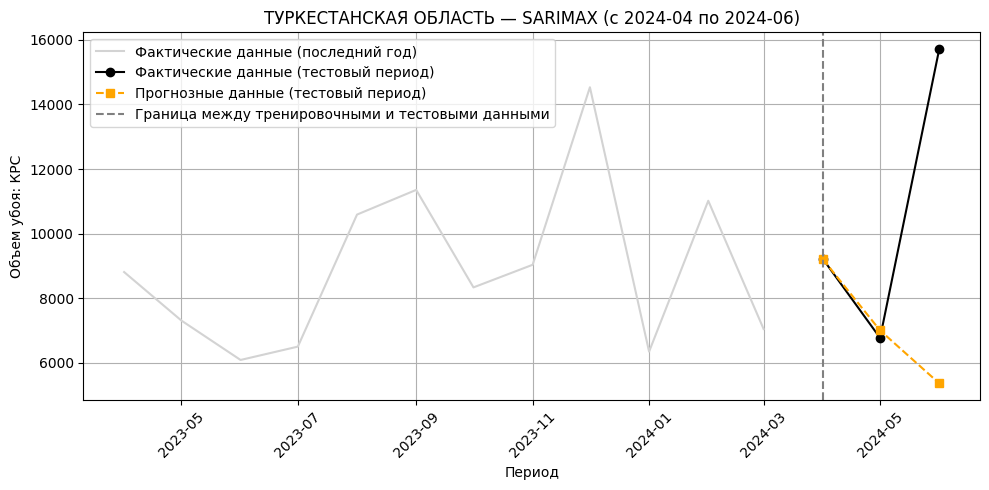

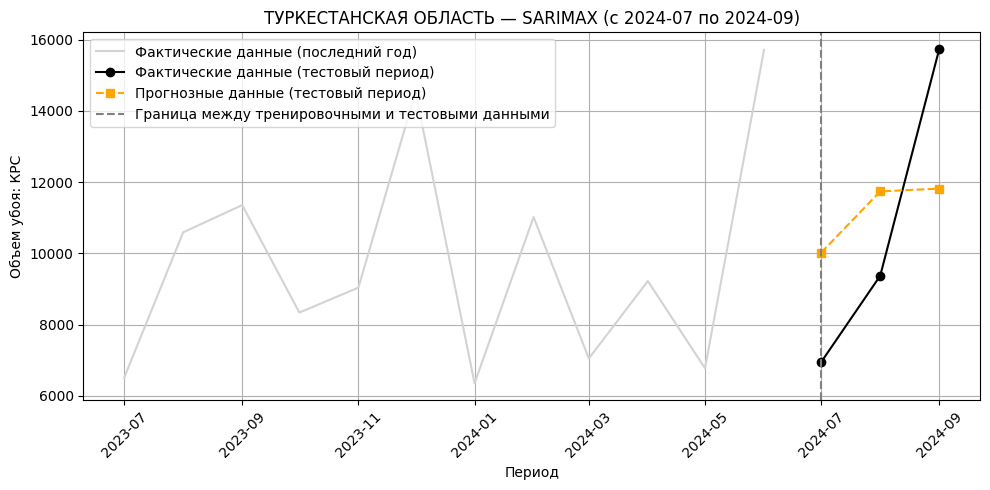

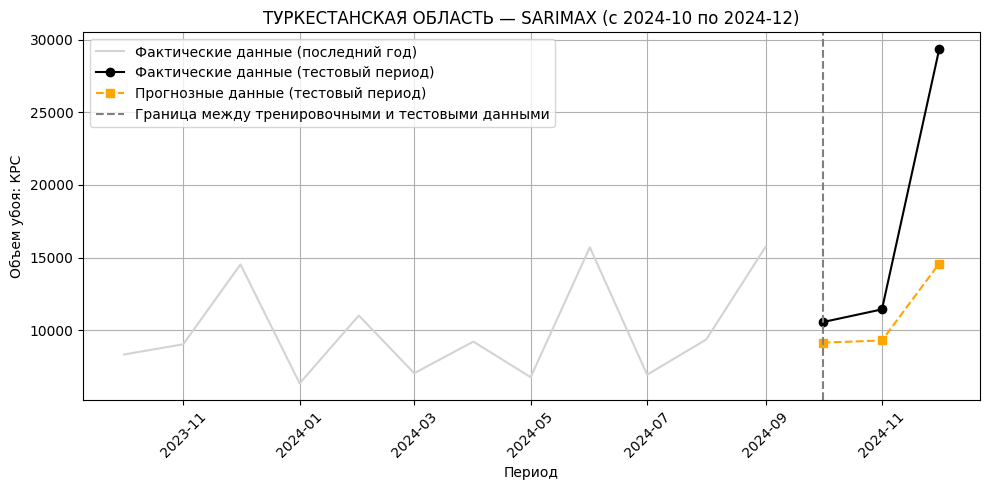

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define your exogenous variables
exog_vars = ['Температура_t-3']

df = df_turkistan.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[exog_vars].reset_index(drop=True)
    exog_test = test_df[exog_vars].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(1, 0, 0),
            seasonal_order=(0, 1, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=3, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ТУРКЕСТАНСКАЯ ОБЛАСТЬ — SARIMAX (с {start} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [31]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)



          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  2754.457434  1972.153741  20.484112            1   
1  2024-04 to 2024-06  5974.637103  3529.273457  23.122286            1   
2  2024-07 to 2024-09  3183.003202  3119.275533  31.456901            1   
3  2024-10 to 2024-12  8647.108630  6102.645484  27.445052            1   
4             Average  5139.801592  3680.837054  25.627088                

  Seasonal order  
0              0  
1              0  
2              0  
3              0  
4                 


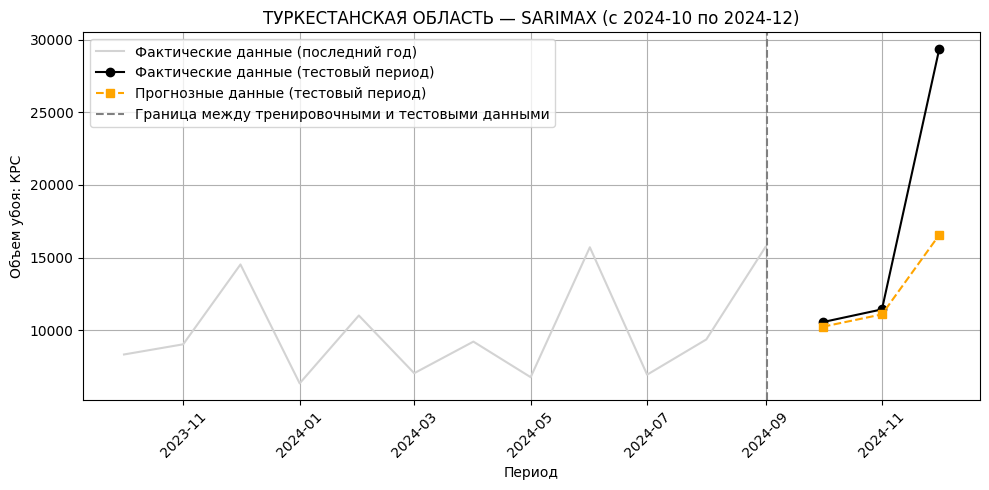

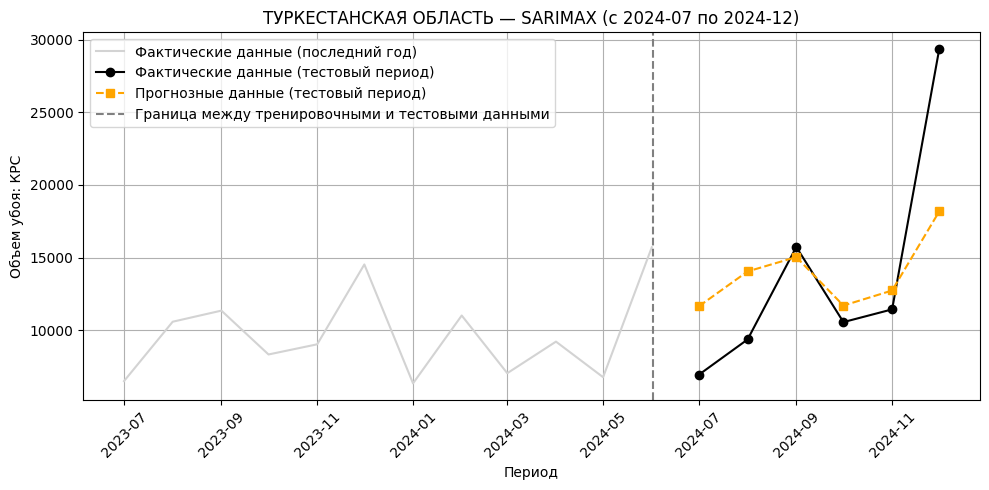

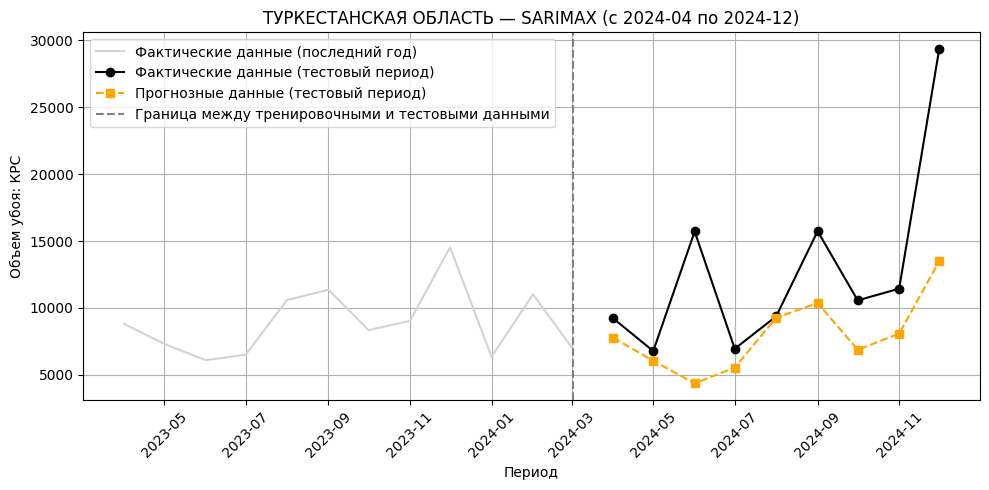

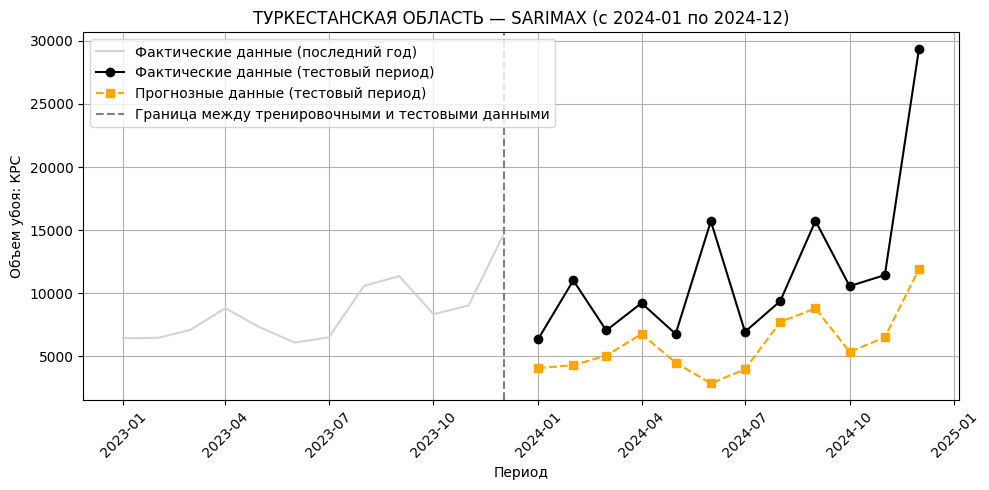

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define your exogenous variables
exog_vars = ['Температура_t-3']

df = df_turkistan.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[exog_vars].reset_index(drop=True)
    exog_test = test_df[exog_vars].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 1, 2),
            seasonal_order=(0, 1, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=horizon, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ТУРКЕСТАНСКАЯ ОБЛАСТЬ — SARIMAX (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [33]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)

          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-10 to 2024-12  7388.288651  4483.690109  16.529953            0   
1  2024-07 to 2024-12  5358.757564  3948.548306  30.378334            0   
2  2024-04 to 2024-12  6982.356556  4813.195624  30.272730            0   
3  2024-01 to 2024-12  7335.577545  5642.747465  43.620456            0   
4             Average  6766.245079  4722.045376  30.200368                

  Seasonal order  
0              0  
1              0  
2              0  
3              0  
4                 


#### Prophet

18:53:20 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing


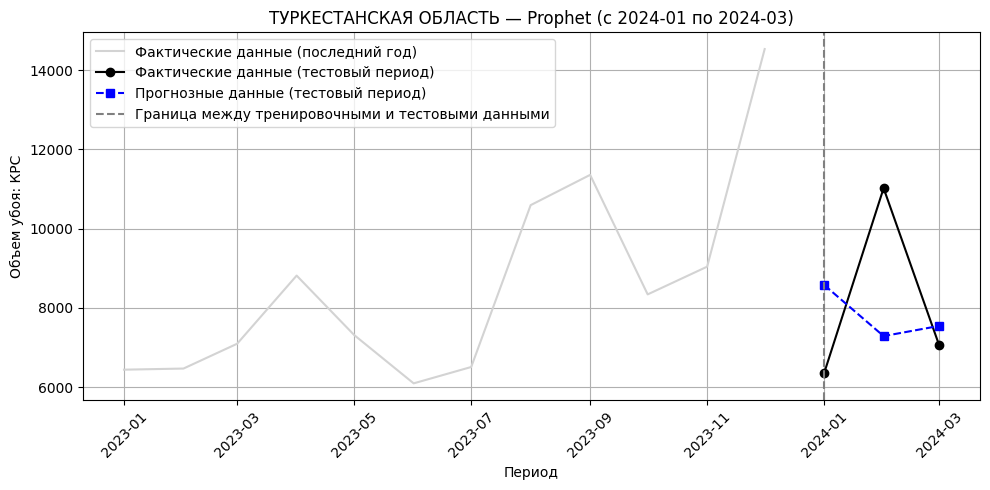

18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing


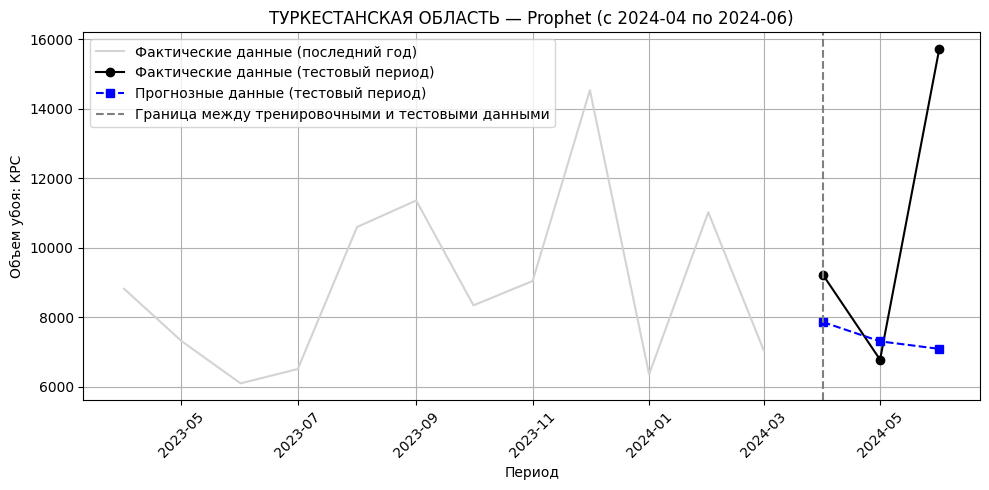

18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing


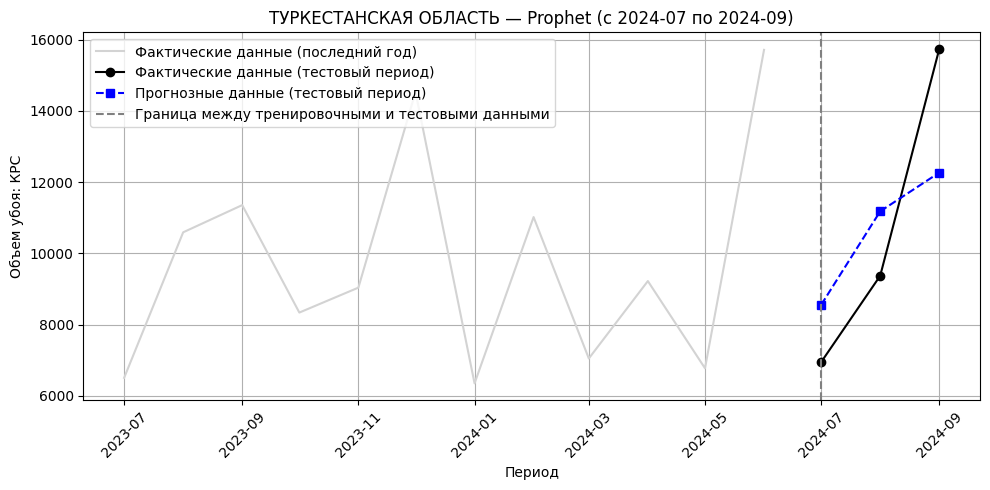

18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing


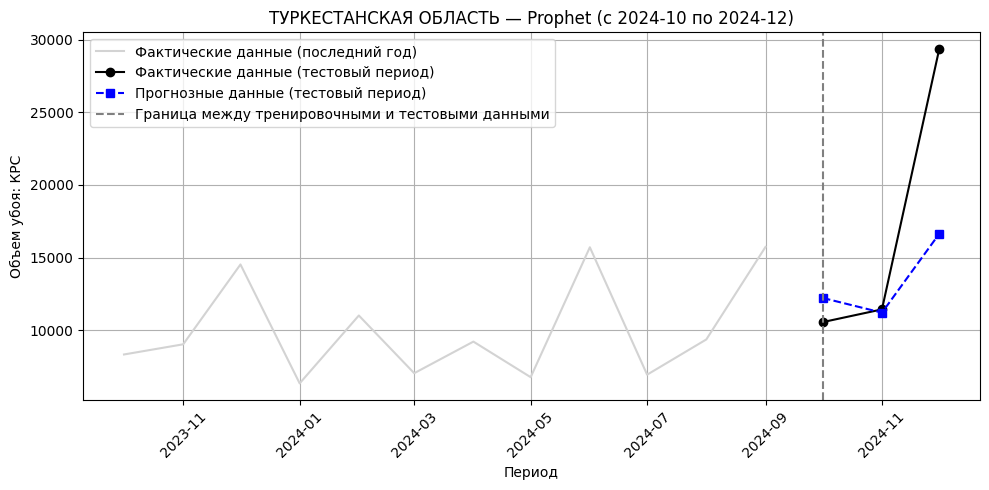

In [34]:
# Prepare Data
df = df_turkistan.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

# Define 4 test periods
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Train/test split
    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Initialize Prophet
    model = Prophet()

    # Optional: add regressors
    # model.add_regressor("Температура")
    # model.add_regressor("Осадки")
    # model.add_regressor("Поголовье: КРС")
    # prophet_train["Температура"] = train_df["Температура"].values
    # prophet_test["Температура"] = test_df["Температура"].values

    # Fit
    model.fit(prophet_train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=3, freq="M")
    forecast = model.predict(future)
# forecast
# prophet_test

    # Extract forecast for test period only
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ТУРКЕСТАНСКАЯ ОБЛАСТЬ — Prophet (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [35]:
results_df = pd.DataFrame(results)
avg = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg])], ignore_index=True)
print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-01 to 2024-03  2525.727181  2150.802418  25.302821
1  2024-04 to 2024-06  5053.188676  3506.991277  25.827074
2  2024-07 to 2024-09  2442.348470  2295.544667  21.496152
3  2024-10 to 2024-12  7402.042199  4865.768943  20.331396
4             Average  4355.826631  3204.776826  23.239361


18:53:32 - cmdstanpy - INFO - Chain [1] start processing



🔹 Прогноз на 3 месяцев


18:53:32 - cmdstanpy - INFO - Chain [1] done processing


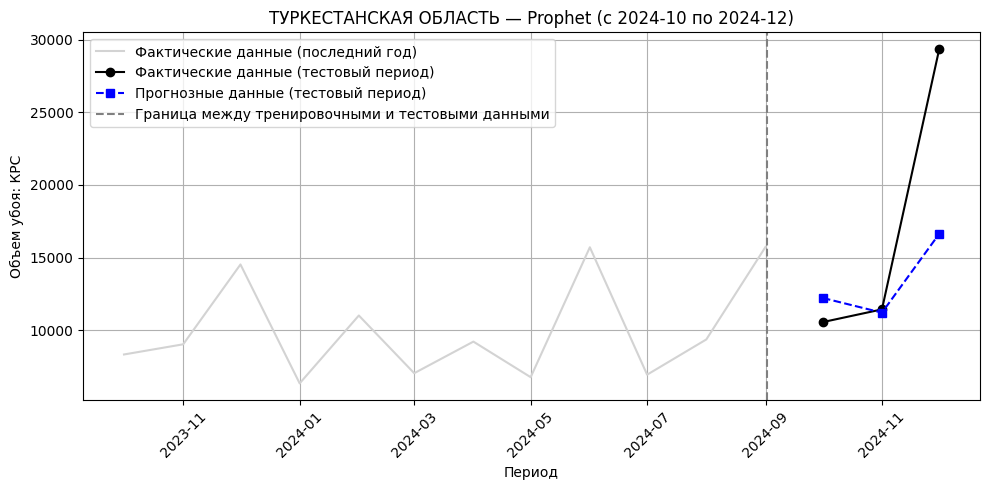

18:53:33 - cmdstanpy - INFO - Chain [1] start processing



🔹 Прогноз на 6 месяцев


18:53:33 - cmdstanpy - INFO - Chain [1] done processing


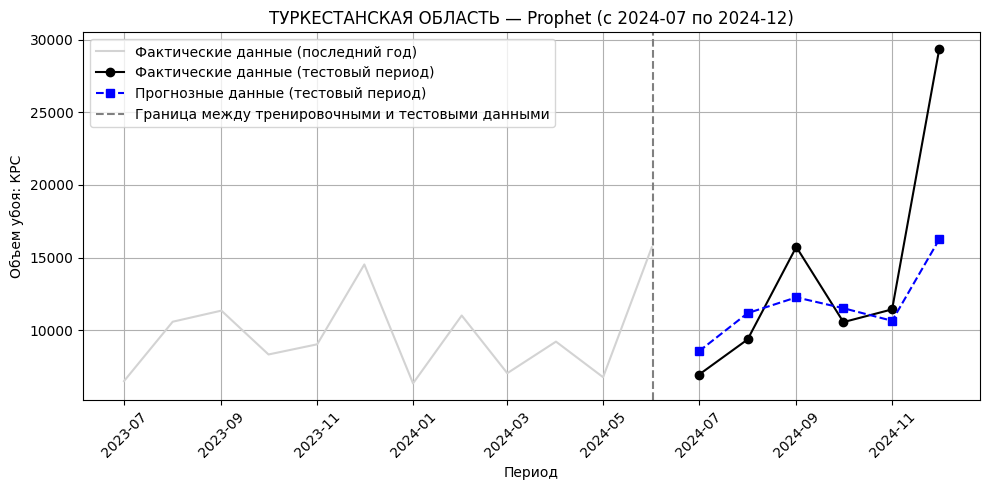

18:53:33 - cmdstanpy - INFO - Chain [1] start processing



🔹 Прогноз на 9 месяцев


18:53:34 - cmdstanpy - INFO - Chain [1] done processing


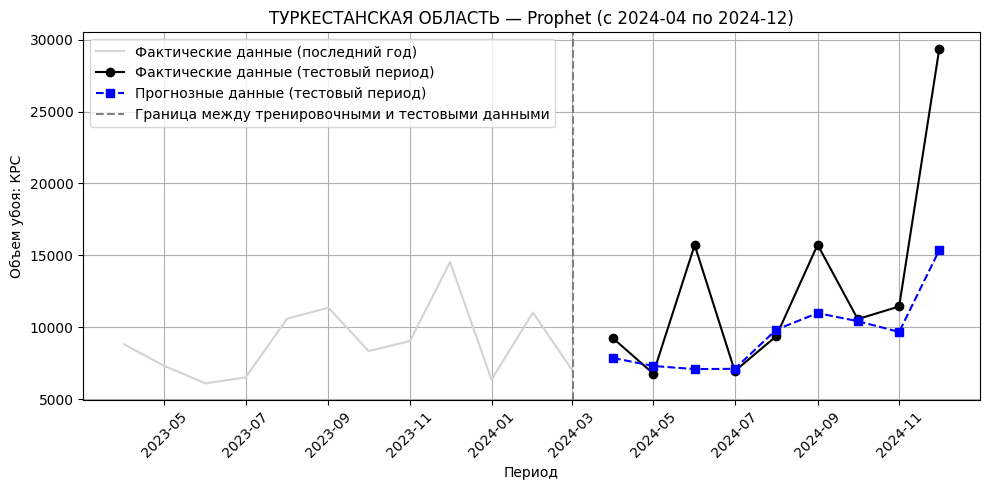

18:53:34 - cmdstanpy - INFO - Chain [1] start processing



🔹 Прогноз на 12 месяцев


18:53:35 - cmdstanpy - INFO - Chain [1] done processing


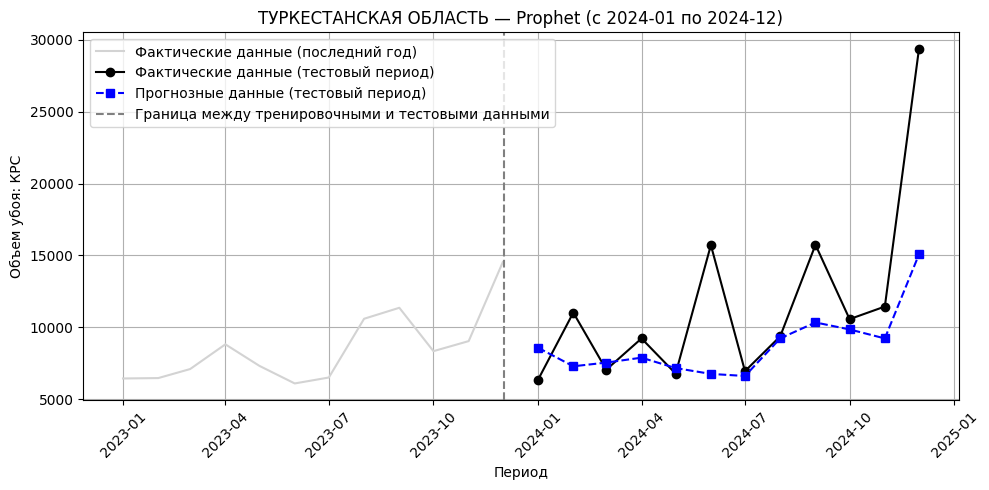

In [36]:
# Prepare data
df = df_turkistan.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])
target = "Объем убоя: КРС"

# Define forecast horizons
horizons = [3, 6, 9, 12]
results = []

for horizon in horizons:
    print(f"\n🔹 Прогноз на {horizon} месяцев")

    # Define train/test split
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Fit Prophet
    model = Prophet()
    model.fit(prophet_train)

    # Forecast
    future = model.make_future_dataframe(periods=horizon, freq="M")
    forecast = model.predict(future)

    # Extract matching forecasted months
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ТУРКЕСТАНСКАЯ ОБЛАСТЬ — Prophet (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [37]:
# Summary table
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Horizon (months)"] = "Среднее"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)

          Test period         RMSE          MAE   MAPE (%) Horizon (months)
0  2024-10 to 2024-12  7402.042199  4865.768943  20.331396              NaN
1  2024-07 to 2024-12  5640.342453  3620.279161  20.834092              NaN
2  2024-04 to 2024-12  5758.559687  3532.987614  19.924186              NaN
3  2024-01 to 2024-12  5324.582886  3353.066033  22.386086              NaN
4                 NaN  6031.381806  3843.025438  20.868940          Среднее


strength of correlation:
https://link.springer.com/article/10.1057/jt.2009.5#
https://resources.nu.edu/statsresources/correlation